##Importing data from Github

In [1]:
import pandas as pd

# reporting date 2024/06/30 13F-HR
#  url = "https://raw.githubusercontent.com/Kei-Sanada/Holdings-of-Numerai-GP-LLC/bb2165d3364053639dcd53e62ebf7d2feaccccd7/History_Numerai_13F-HR.xlsx"

# reporting date 2024/09/30 13F-HR
url = "https://raw.github.com/Kei-Sanada/Holdings-of-Numerai-GP-LLC/ea37da6b4930f5c4e89b0a1b52cb2b2a7e187b76/History_Numerai_13F-HR.xlsx"


# Import Excel file and store sheet "ALL" in DataFrame
numerai_13f_history = pd.read_excel(url, sheet_name='ALL')

# Convert NaN value to 0
numerai_13f_history.fillna(0, inplace=True)

In [2]:
# Display DataFrame numerai_13f_history in tabular format
from IPython.display import display
display(numerai_13f_history.style.hide(axis="index"))

nameOfIssuer,cusip,2022-12-31 00:00:00,2023-03-31 00:00:00,2023-06-30 00:00:00,2023-09-30 00:00:00,2023-12-31 00:00:00,2024-03-31 00:00:00,2024-06-30 00:00:00,2024-09-30 00:00:00
ABM INDS INC,000957100,0.000000,0.000000,0.000000,0.000000,0.000000,1882473.000000,0.000000,0.000000
AGCO CORP,001084102,0.000000,0.000000,0.000000,0.000000,0.000000,1764107.000000,0.000000,0.000000
ABERCROMBIE & FITCH CO,002896207,0.000000,0.000000,0.000000,956599.000000,0.000000,0.000000,0.000000,0.000000
ADVANCED MICRO DEVICES INC,007903107,0.000000,0.000000,0.000000,508342.000000,0.000000,0.000000,0.000000,0.000000
AIRBNB INC,009066101,0.000000,0.000000,0.000000,317916.000000,0.000000,0.000000,0.000000,2865018.000000
AIR PRODS & CHEMS INC,009158106,0.000000,0.000000,0.000000,0.000000,0.000000,446261.000000,0.000000,0.000000
ALAMO GROUP INC,011311107,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1756123.000000,2659619.000000
ALARM COM HLDGS INC,011642105,0.000000,539504.000000,1586059.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ALBANY INTL CORP,012348108,0.000000,0.000000,0.000000,531657.000000,398871.000000,246773.000000,0.000000,0.000000
ALCOA CORP,013872106,0.000000,0.000000,9118416.000000,2337267.000000,278290.000000,0.000000,1540441.000000,1608323.000000


# Analysis

##AUM

In [3]:
import matplotlib.pyplot as plt

In [4]:
numerai_13f_history_aum = numerai_13f_history.copy()
numerai_13f_history_aum = numerai_13f_history_aum.drop(columns=['nameOfIssuer', 'cusip']).sum().reset_index()
numerai_13f_history_aum.columns = ['Date', 'AUM']

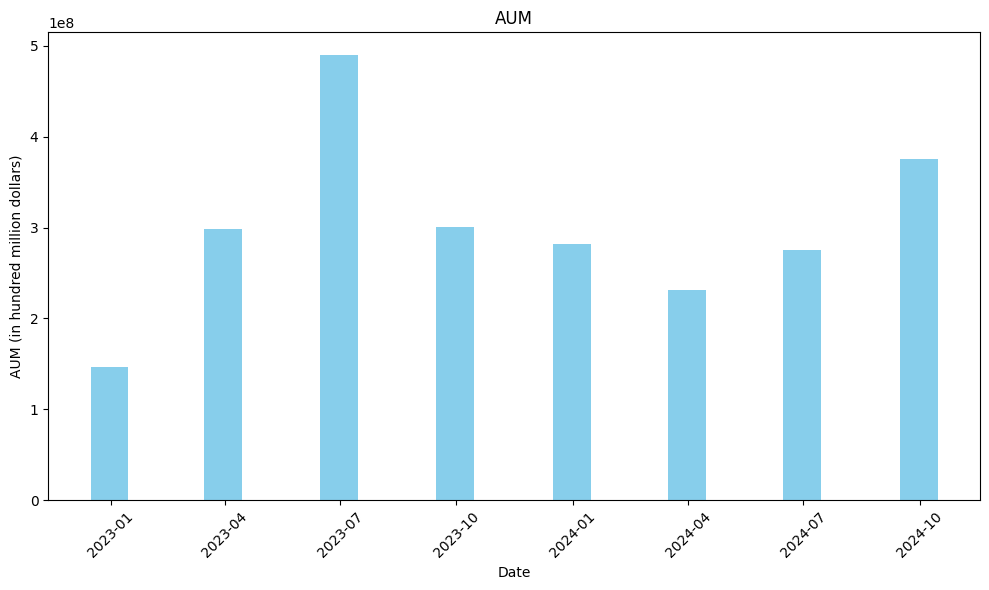

In [5]:
# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(numerai_13f_history_aum['Date'], numerai_13f_history_aum['AUM'], color='skyblue', width=30.0, align='center')

plt.title('AUM')
plt.xlabel('Date')
plt.ylabel('AUM (in hundred million dollars)')

plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [6]:
# Display numbers as dollar amounts
numerai_13f_history_aum['AUM'] = numerai_13f_history_aum['AUM'].apply(lambda x: f"${x:,.2f}")

print(numerai_13f_history_aum.to_string(index=False))

      Date             AUM
2022-12-31 $146,573,876.00
2023-03-31 $298,912,467.00
2023-06-30 $490,498,077.00
2023-09-30 $300,843,187.00
2023-12-31 $282,465,844.00
2024-03-31 $231,559,353.00
2024-06-30 $275,042,324.00
2024-09-30 $375,057,732.00


##AUM Box Plot

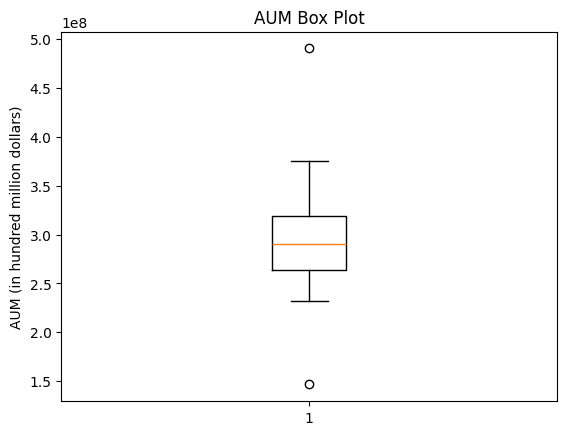

In [7]:
# Remove dollar signs and commas, then convert to float
numerai_13f_history_aum['AUM'] = numerai_13f_history_aum['AUM'].replace({'\$': '', ',': ''}, regex=True).astype(float)

plt.boxplot(numerai_13f_history_aum['AUM'])
plt.ylabel('AUM (in hundred million dollars)')
plt.title('AUM Box Plot')
plt.show()

# Try adding a Ticker
I couldn't find free solution to convert cusip to Ticker.\
If you have a better way, please let me know.

The following process takes about 20 minutes.\
Also, it is not always possible to get the correct ticker.

In [8]:
#Install yahooquery library
!pip install yahooquery

In [9]:
from yahooquery import search

def get_ticker_symbol(company_name):
    try:
        result = search(company_name)
        if 'quotes' in result and len(result['quotes']) > 0:
            return result['quotes'][0]['symbol']
        else:
            return None  # Return None if JSONDecodeError is encountered
    except:
        return None  # Returns None in case of other errors

In [10]:
import time

# Create a list of company names
company_names = numerai_13f_history['nameOfIssuer']

# Create an empty list to store the ticker symbols
ticker_symbols = []

# Iterate over the company names and get the ticker symbols
for company_name in company_names:
    time.sleep(0.5)  # Add a delay of 0.5 second between each request
    ticker_symbol = get_ticker_symbol(company_name)
    ticker_symbols.append(ticker_symbol)


In [11]:
# Add ticker symbol as a new column
numerai_13f_history_ticker = numerai_13f_history.copy()
numerai_13f_history_ticker.insert(2, 'ticker', ticker_symbols)

In [13]:
numerai_13f_history_ticker.to_excel('Numerai_13F_History_with_Ticker.xlsx', index=False)
display(numerai_13f_history_ticker.style.hide(axis="index"))

nameOfIssuer,cusip,ticker,2022-12-31 00:00:00,2023-03-31 00:00:00,2023-06-30 00:00:00,2023-09-30 00:00:00,2023-12-31 00:00:00,2024-03-31 00:00:00,2024-06-30 00:00:00,2024-09-30 00:00:00
ABM INDS INC,000957100,None,0.000000,0.000000,0.000000,0.000000,0.000000,1882473.000000,0.000000,0.000000
AGCO CORP,001084102,AGCO,0.000000,0.000000,0.000000,0.000000,0.000000,1764107.000000,0.000000,0.000000
ABERCROMBIE & FITCH CO,002896207,ANF,0.000000,0.000000,0.000000,956599.000000,0.000000,0.000000,0.000000,0.000000
ADVANCED MICRO DEVICES INC,007903107,AMD,0.000000,0.000000,0.000000,508342.000000,0.000000,0.000000,0.000000,0.000000
AIRBNB INC,009066101,ABNB,0.000000,0.000000,0.000000,317916.000000,0.000000,0.000000,0.000000,2865018.000000
AIR PRODS & CHEMS INC,009158106,None,0.000000,0.000000,0.000000,0.000000,0.000000,446261.000000,0.000000,0.000000
ALAMO GROUP INC,011311107,ALG,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1756123.000000,2659619.000000
ALARM COM HLDGS INC,011642105,None,0.000000,539504.000000,1586059.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ALBANY INTL CORP,012348108,None,0.000000,0.000000,0.000000,531657.000000,398871.000000,246773.000000,0.000000,0.000000
ALCOA CORP,013872106,AA,0.000000,0.000000,9118416.000000,2337267.000000,278290.000000,0.000000,1540441.000000,1608323.000000
